# Possession time divided by zone

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'

## Load data

In [3]:
yr = '2024'

In [4]:
df = pd.read_csv('data/BDC_' + yr + '_Data_Cleaned.csv', index_col=0)
entries = pd.read_csv('data/BDC_' + yr + '_Zone_Entries.csv', index_col=0)
df['Plays of Interest'] = pd.read_csv('data/BDC_' + yr + '_Plays_of_Interest.csv', index_col=0)

## Create seperate sequences for different zones

In [5]:
# add columns with flag whether team gained or maintained possession on play
df['Pos Gained 2'] = (
    (df['Date'].shift(1) != df['Date']) | 
    (df['Period'].shift(1) != df['Period']) | 
    (df['Team'].shift(1) != df['Team']) |
    (df['Event'] == 'Faceoff Win') |
    (
        ((df['X Coordinate'].shift(1) < 75) & (df['X Coordinate'] > 75)) | # exit D zone
        ((df['X Coordinate'].shift(1) < 125) & (df['X Coordinate'] > 125)) | # enter ozone
        ((df['X Coordinate'].shift(1) > 75) & (df['X Coordinate'] < 75)) | # enter D zone
        ((df['X Coordinate'].shift(1) > 125) & (df['X Coordinate'] < 125)) # exit ozone
    )
)
df['Pos Lost 2'] = (
    (df['Date'].shift(-1) != df['Date']) | 
    (df['Period'].shift(-1) != df['Period']) | 
    (df['Team'].shift(-1) != df['Team']) |
    (df['Event'].shift(-1) == 'Faceoff Win') |
    (
        ((df['X Coordinate'].shift(-1) < 75) & (df['X Coordinate'] > 75)) | # exit D zone
        ((df['X Coordinate'].shift(-1) < 125) & (df['X Coordinate'] > 125)) | # enter ozone
        ((df['X Coordinate'].shift(-1) > 75) & (df['X Coordinate'] < 75)) | # enter D zone
        ((df['X Coordinate'].shift(-1) > 125) & (df['X Coordinate'] < 125)) # exit ozone
    )
)
df['Pos Retained 2'] = (
    (df['Date'].shift(-1) == df['Date']) & 
    (df['Period'].shift(-1) == df['Period']) & 
    (df['Team'].shift(-1) == df['Team']) & 
    (df['Event'].shift(-1) != 'Faceoff Win') &
    (
        ((df['X Coordinate'].shift(-1) < 75) & (df['X Coordinate'] < 75)) | # stay in D zone
        ((df['X Coordinate'].shift(-1) > 125) & (df['X Coordinate'] > 125)) | # stay in O zone
        (
            (
                (df['X Coordinate'].shift(-1) > 75) & 
                (df['X Coordinate'].shift(-1) < 125)
            ) & 
            (
                (df['X Coordinate'] > 75) & 
                (df['X Coordinate'] < 125)
            )
        ) # stay in N zone
    )
)

In [6]:
# add column with possession time during play sequences
df['Sequence ID 2'] = df['Pos Gained 2'].cumsum()
start_times = df.groupby('Sequence ID 2')['Time'].min().to_dict()
df['Possession Time 2'] = df['Time'] - df['Sequence ID 2'].map(start_times)
# add extra seconds if the event lasted until the start of the next event
end_t = df.loc[
    (
        (df['Event'].shift(1).isin(['Penalty Taken', 'Play', 'Takeaway', 'Puck Recovery']) & 
        df['Possession Gained']) |
        (df['Pos Gained 2'] & ~df['Possession Gained'])
    ),
    'Time'
]
end_t.index -= 1
start_t = df.loc[
    (
        (df['Event'].isin(['Penalty Taken', 'Play', 'Takeaway', 'Puck Recovery']) & 
        df['Possession Gained'].shift(-1)) |
        (df['Pos Gained 2'].shift(-1) & ~df['Possession Gained'].shift(-1).fillna(False))
    ),
    'Time'
]

df.loc[
    (
        (df['Event'].isin(['Penalty Taken', 'Play', 'Takeaway', 'Puck Recovery']) & 
        df['Possession Gained'].shift(-1)) |
        (df['Pos Gained 2'].shift(-1) & ~df['Possession Gained'].shift(-1).fillna(False))
    ),
    'Possession Time 2'
] +=  end_t - start_t

## Group by zone

In [7]:
pk = df.loc[df['Team Status'] == 'PK']
pk_d = pk.loc[(pk['X Coordinate'] < 75)]
pk_o = pk.loc[(pk['X Coordinate'] > 125)]
pk_n = pk.loc[(pk['X Coordinate'] >= 75) & (pk['X Coordinate'] <= 125)]

In [8]:
num_pens = max(pk['Penalty ID'].unique())

In [9]:
g1 = pk_o.groupby(['Penalty ID', 'Sequence ID 2'])
posf_o = g1['Possession Time 2'].max().groupby(level=0).sum()
posf_o = posf_o.reindex(np.arange(1, num_pens + 1), fill_value=0)
posf_o.name = 'Possession O Zone'

In [10]:
g2 = pk_n.groupby(['Penalty ID', 'Sequence ID 2'])
posf_n = g2['Possession Time 2'].max().groupby(level=0).sum()
posf_n = posf_n.reindex(np.arange(1, num_pens + 1), fill_value=0)
posf_n.name = 'Possession N Zone'

In [11]:
g3 = pk_d.groupby(['Penalty ID', 'Sequence ID 2'])
posf_d = g3['Possession Time 2'].max().groupby(level=0).sum()
posf_d = posf_d.reindex(np.arange(1, num_pens + 1), fill_value=0)
posf_d.name = 'Possession D Zone'

In [12]:
pos_df = pd.concat([posf_d, posf_n, posf_o], axis=1)

In [13]:
pos_df['Total Possession'] = posf_d + posf_n + posf_o

In [14]:
p_df = pd.read_csv('data/BDC_' + yr + '_Analysis.csv', index_col=0)

In [15]:
p_df.index += 1

In [16]:
pos_df['Neutral Control'] = p_df['Neutral Control']

## Analyze

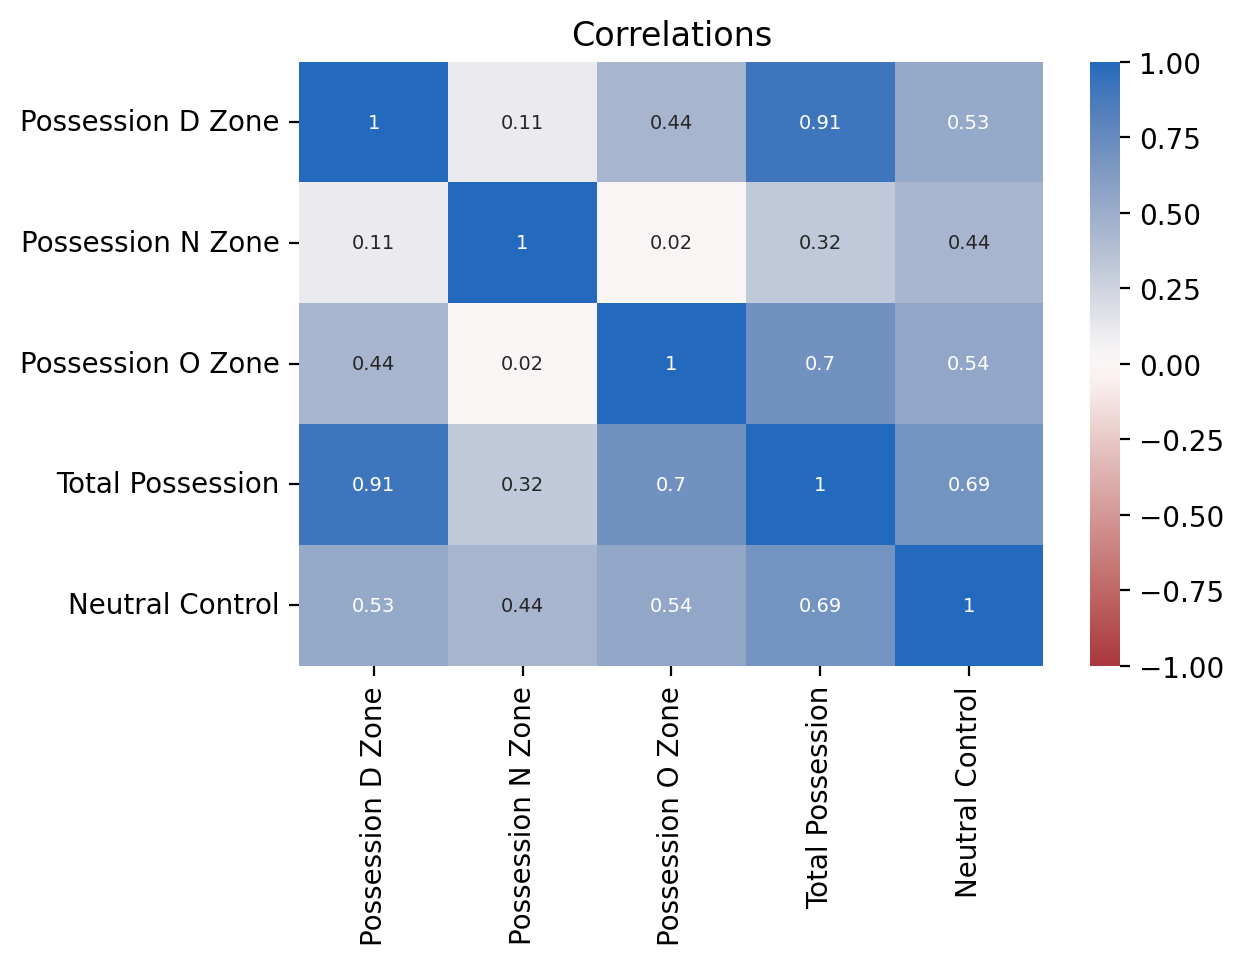

In [17]:
corr = pos_df.corr()
g = sns.heatmap(corr.round(2), annot=True, cmap='vlag_r', annot_kws={'size': 7}, vmin=-1, vmax=1)
g.set_title('Correlations')
plt.show()

In [18]:
pos_df.loc[pos_df['Neutral Control'] > 0]['Possession N Zone'].mean() \
+ pos_df.loc[pos_df['Neutral Control'] > 0]['Possession O Zone'].mean()

11.5

In [19]:
pos_df.loc[pos_df['Neutral Control'] == 0]['Possession N Zone'].mean() \
+ pos_df.loc[pos_df['Neutral Control'] == 0]['Possession O Zone'].mean()

3.391304347826087

In [20]:
pos_df.loc[pos_df['Neutral Control'] > 0]['Possession O Zone'].mean()

7.333333333333333

In [21]:
pos_df.loc[pos_df['Neutral Control'] == 0]['Possession O Zone'].mean()

2.0869565217391304